# This is the Drive Cycle Generation tool jupyter notebook, which should have the same content as the DC_gen_tool.py

In [3]:
import os
import math
from sympy import *
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, least_squares
from scipy.optimize import minimize as sp_minimize
from scipy import special
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt
import lmfit
import random
from scipy.interpolate import interp1d
np.set_printoptions(threshold=sys.maxsize)

In [1]:
def load_csv_data(file_name, subdir=''):
    """
    Loads data from .csv file in to DataFrame

    :param file_name: .csv file name in string
    :param subdir: optional parameter to specify the subdirectory of the file
    :return: extracted data in DataFrame
    """

    file_dir = os.path.realpath('../')
    print(file_dir)
    for root, dirs, files in os.walk(file_dir):
        if root.endswith(subdir):
            for name in files:
                if name == file_name:
                    file_path = os.path.join(root, name)

    df = pd.read_csv(file_path)

    return df

In [2]:
def LF_Noise(component = 1):
    """ Inital parameters and bounds for each paramter according to LF (0-0.01Hz)in the paper
    """
    LMparams = Parameters()

    # The code below is to load the initial paramters if we are running the NLLSR on all 3 components at once

    LMparams.add('A1_FS', value = 10.)
    LMparams.add('A2_FS', value = 10.)
    LMparams.add('A3_FS', value = 10.)
    LMparams.add('w1_FS', value = 0, min = 0, max = 0.01*2*math.pi)
    LMparams.add('w2_FS', value = 0.005*2*math.pi, min = 0, max = 0.01*2*math.pi)
    LMparams.add('w3_FS', value = 0.01*2*math.pi, min = 0, max = 0.01*2*math.pi)
    LMparams.add('phi1_FS', value = 0, min = -math.pi, max = math.pi)
    LMparams.add('phi2_FS', value = 0, min = -math.pi, max = math.pi)
    LMparams.add('phi3_FS', value = 0, min = -math.pi, max = math.pi)

    # The code below is to load the initial paramters if we are running the NLLSR on one component at a time

    # if component == 1:
    #     LMparams.add('A_FS', value = 10.)
    #     LMparams.add('w_FS', value = 0, min = 0, max = 0.01*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)
    # elif component == 2:
    #     LMparams.add('A_FS', value = 10.)
    #     LMparams.add('w_FS', value = 0.005*2*math.pi, min = 0, max = 0.01*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)
    # elif component == 3:
    #     LMparams.add('A_FS', value = 10.)
    #     LMparams.add('w_FS', value = 0.01*2*math.pi, min = 0, max = 0.01*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)

    return LMparams

def MF_Noise(component = 1):
    """ Inital parameters and bounds for each paramter according to MF (0.01-0.25Hz) in the paper
    """
    LMparams = Parameters()

    # The code below is to load the initial paramters if we are running the NLLSR on all 3 components at once

    LMparams.add('A1_FS', value = 10.)
    LMparams.add('A2_FS', value = 10.)
    LMparams.add('A3_FS', value = 10.)
    LMparams.add('w1_FS', value = 0.02*2*math.pi, min = 0.01*2*math.pi, max = 0.25*2*math.pi)
    LMparams.add('w2_FS', value = 0.03*2*math.pi, min = 0.01*2*math.pi, max = 0.25*2*math.pi)
    LMparams.add('w3_FS', value = 0.03*2*math.pi, min = 0.01*2*math.pi, max = 0.25*2*math.pi)
    LMparams.add('phi1_FS', value = 0, min = -math.pi, max = math.pi)
    LMparams.add('phi2_FS', value = 0, min = -math.pi, max = math.pi)
    LMparams.add('phi3_FS', value = 0, min = -math.pi, max = math.pi)

    # The code below is to load the initial paramters if we are running the NLLSR on one component at a time

    # if component == 1:
    #     LMparams.add('A_FS', value = 10.)
    #     LMparams.add('w_FS', value = 0.02*2*math.pi, min = 0.01*2*math.pi, max = 0.25*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)
    # elif component == 2:
    #     LMparams.add('A_FS', value = 10.)
    #     LMparams.add('w_FS', value = 0.03*2*math.pi, min = 0.01*2*math.pi, max = 0.25*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)
    # elif component == 3:
    #     LMparams.add('A_FS', value = 10.)
    #     LMparams.add('w_FS', value = 0.03*2*math.pi, min = 0.01*2*math.pi, max = 0.25*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)

    return LMparams

def HF_Noise(component = 1):
    """ Inital parameters and bounds for each paramter according to HF (0.25-0.5Hz) in the paper
    """
    LMparams = Parameters()

    # The code below is to load the initial paramters if we are running the NLLSR on all 3 components at once

    LMparams.add('A1_FS', value = 1.)
    LMparams.add('A2_FS', value = 1.)
    LMparams.add('A3_FS', value = 1.)
    LMparams.add('w1_FS', value = 0.25*2*math.pi, min = 0.25*2*math.pi, max = 0.5*2*math.pi)
    LMparams.add('w2_FS', value = 0.375*2*math.pi, min = 0.25*2*math.pi, max = 0.5*2*math.pi)
    LMparams.add('w3_FS', value = 0.5*2*math.pi, min = 0.25*2*math.pi, max = 0.5*2*math.pi)
    LMparams.add('phi1_FS', value = 0, min = -math.pi, max = math.pi)
    LMparams.add('phi2_FS', value = 0, min = -math.pi, max = math.pi)
    LMparams.add('phi3_FS', value = 0, min = -math.pi, max = math.pi)

    # The code below is to load the initial paramters if we are running the NLLSR on one component at a time

    # if component == 1:
    #     LMparams.add('A_FS', value = 1.)
    #     LMparams.add('w_FS', value = 0.25*2*math.pi, min = 0.25*2*math.pi, max = 0.5*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)
    # elif component == 2:
    #     LMparams.add('A_FS', value = 1.)
    #     LMparams.add('w_FS', value = 0.375*2*math.pi, min = 0.25*2*math.pi, max = 0.5*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)
    # elif component == 3:
    #     LMparams.add('A_FS', value = 1.)
    #     LMparams.add('w_FS', value = 0.5*2*math.pi, min = 0.25*2*math.pi, max = 0.5*2*math.pi)
    #     LMparams.add('phi_FS', value = 0, min = -math.pi, max = math.pi)

    return LMparams

In [4]:
class DP(object):
    """ Module 3: Drive Pulse
    """
    # def __init__(self, pulse_duration):
    #     """ Constructor takes in pulse duration and creates instances of inverse cdfs for each of the intersted parameters needed to
    #         generate the drive pulse. Creates self.parameter dictionary containing all relevant parameters.
    #     """
    #     self.pulse_duration = pulse_duration 
    #     self.total_t = np.linspace(0, 1000*self.pulse_duration, (1000*self.pulse_duration)+1)
    #     self.accel_inv_cdf_obj = self.create_inv_cdf_objects(Acceleration())
    #     self.cruising_duration_inv_cdf_obj = self.create_inv_cdf_objects(Cruising_Duration())
    #     self.avg_cruising_speed_inv_cdf_obj = self.create_inv_cdf_objects(Average_Crusing_Speed())
    #     self.decel_inv_cdf_obj = self.create_inv_cdf_objects(Deceleration())
    #     self.random_select_params()
    #     self.params = self.parameters_for_drive_cycle(self.accel_value, self.decel_value, self.cruising_duration_value, self.avg_cruising_speed_value)
    #     print(self.params)

    def __init__(self, pulse_duration, extract_obj, seed = 10):
        """ Constructor takes in pulse duration and extraction obj, then creates instances of inverse cdfs for each of the interested 
        parameters needed to generate the drive pulse. Creates self.parameter dictionary containing all relevant parameters.
        """
        np.random.seed(seed)
        self.pulse_duration = pulse_duration 
        self.total_t = np.linspace(0, 1000*self.pulse_duration, (1000*self.pulse_duration)+1)
        self.accel_inv_cdf_obj = self.create_inv_cdf_objects(extract_obj.accel_obj)
        self.cruising_duration_inv_cdf_obj = self.create_inv_cdf_objects(extract_obj.cd_obj)
        self.avg_cruising_speed_inv_cdf_obj = self.create_inv_cdf_objects(extract_obj.avg_cs_obj)
        self.decel_inv_cdf_obj = self.create_inv_cdf_objects(extract_obj.decel_obj)
        self.idle_inv_cdf_obj = self.create_inv_cdf_objects(extract_obj.idle_obj, param_obj = Gaussian_idle_param())
        

    def create_inv_cdf_objects(self, attribute_obj, param_obj = Gaussian_param(), num_of_gauss = 2):
        """
        Takes in one of parameter's classes needed for driving pulse and instantiates object for the inverse_cdf
        """
        #create a probability function object for attribute with its attribute histogram data
        attribute_prob_obj = Probability_Functions(attribute_obj.bins, attribute_obj.data_points,num_of_gauss)
        #fit the histogram
        fitted_obj = attribute_prob_obj.NLLSR(param_obj)
        # create inverse cdf object
        inv_cdf_obj = inv_cdf(attribute_prob_obj)

        return inv_cdf_obj

    def random_select_params(self):
        """
        Randomly generates numbers from 0 to 1 to randomly select values for parameters using their inverse cdf
        """
        list1 = np.random.rand(5).tolist()
        random_numbers = [int(round(1000*element)) for element in list1]
        print(random_numbers)
        self.accel_value = self.accel_inv_cdf_obj.get_value(random_numbers.pop())
        self.cruising_duration_value = self.cruising_duration_inv_cdf_obj.get_value(random_numbers.pop())
        self.avg_cruising_speed_value = self.avg_cruising_speed_inv_cdf_obj.get_value(random_numbers.pop())
        self.decel_value = self.decel_inv_cdf_obj.get_value(random_numbers.pop())
        self.idle_duration_value = self.idle_inv_cdf_obj.get_value(random_numbers.pop())

    def crusing_with_noise(self, time_array, velocity_noise_obj):
        """
        time_array: array of timestamps to compute for corresponding velocity noise using fitted model
        velocity_noise_obj: VN object containing fitted model and respective parameters for 3 freq components
        
        return:: cruising_with_noise set of speed values containing average cruising speed superimposed on velocity noise 
        """
        #resets time to match the specified duration of the driving pulse
        velocity_noise_obj.set_t(time_array)
        #returns velocity noise speed values (y axis)
        velocity_noise = velocity_noise_obj.final_curve()
        #scale the velocity noise so that velocity during crusing does not go negative
        scaled_velocity_noise = self.scale_velocity_noise(velocity_noise)
        # scale vn again to have the ratio between velocity noise and average cruising speed to be the same as the sampled velocity noise
        scaled_velocity_noise = velocity_noise_obj.noise_speed_ratio * scaled_velocity_noise
        #adds velocity noise speed values (y axis) to static cruising speed
        cruising_with_noise =  scaled_velocity_noise + self.params["cruising speed"]

        plt.plot(time_array, cruising_with_noise)
        plt.ylabel('speed (m/s)')
        plt.xlabel('time (s)')
        plt.show()
        return cruising_with_noise

    def scale_velocity_noise(self, velocity_noise):
        # get the minimum velocity of the velocity noise component only (centered around '0')
        min_vn = min(velocity_noise)
        # get the minimum velocity of velocity noise with cruising speed
        min_cruise_with_vn = min_vn + self.params["cruising speed"]
        # only scale the velocity noise if it results in a negative cruising with vn speed value
        if min_cruise_with_vn <= 0:
            # find the scale ratio that causes the lowest of the cruise with vn speed value to be 0
            scale = self.params["cruising speed"]/(-min_vn)
            print(scale)
            # round the value down
            scale = int(math.floor(100*scale))
            print(scale)
            # scale the vn
            scaled_vn = (scale/100) * velocity_noise
            return scaled_vn
        return velocity_noise

    def parameters_for_drive_cycle(self, acceleration, decceleration, cruising_duration, average_cruising_speed):
        """
        accepts as parameters the 4 randomly selected values from the inverse cdfs, computes other parameters and returns
        this as a dictionary
        """
        #computes acceleration time by using average cruising speed as initial speed of cruising duration
        acceleration_time= 1000 * average_cruising_speed / acceleration
        #computes decceleration time by using average cruising speed as final speed of cruising duration
        decceleration_time = 1000 * average_cruising_speed / decceleration
        #computes idle time by subtracting all other durations from total pulse duration
        idle_time = (1000*self.pulse_duration) - acceleration_time - decceleration_time - (1000 * cruising_duration)
        
        #constructs parameters dictionary containing everything needed to generate driving pulse
        parameters = {"acceleration": acceleration,
                      "decceleration" : decceleration,
                      "acceleration duration": round(acceleration_time),
                      "decceleration duration": round(decceleration_time),
                      "cruising duration" : round(1000 * cruising_duration),
                      "cruising speed" : average_cruising_speed,
                      "idle duration" : idle_time,
                      "total duration": 1000*self.pulse_duration
                      }
        return parameters

    def generate_driving_pulse(self, velocity_noise_obj):
        """ Function to be called from outside the class that outputs plot of generated driving pulse
        """
        self.random_select_params()
        self.params = self.parameters_for_drive_cycle(self.accel_value, self.decel_value, self.cruising_duration_value, self.avg_cruising_speed_value)
        print(self.params)
        # Call cruising_with_noise method to return corresponding values (y axis) for cruising
        # Inputs the whole pulse duration as cruise duration therefore extra values are present
        # print(self.total_t)
        # print(self.params["acceleration duration"])
        # print(np.where(self.total_t[:]==self.params["acceleration duration"]))
        # print(np.where(self.total_t[:]==self.params["acceleration duration"])[0][0])
        # print(self.total_t[np.where(self.total_t[:]==self.params["acceleration duration"])[0][0]:]/1000)
        speed_while_cruising_extra_values = self.crusing_with_noise(self.total_t[np.where(self.total_t[:]==self.params["acceleration duration"])[0][0]:np.where(self.total_t[:]==(self.params["acceleration duration"]+self.params["cruising duration"]))[0][0]]/1000, velocity_noise_obj)
        # computes initial cruising speed with velocity noise
        initial_cruising_speed = speed_while_cruising_extra_values[0]
        # print('initial_cruising_speed:{}'.format(initial_cruising_speed))
        # print(self.params["acceleration"])
        # computes actual acceleartion duration using the caluclated initial speed
        # no longer is using the estimate of initial= avergae cruising speed as in the parameters_for_drive_cycle method
        self.params["acceleration duration"] = round(1000 * initial_cruising_speed / self.params["acceleration"])
        # print('accel_duration:{}'.format(self.params["acceleration duration"]))
        # print(self.total_t)
        # print(1000*self.params["acceleration duration"])
        # print(np.where(self.total_t[:]==self.params["acceleration duration"]))
        
        # Retrieves x axis (time steps) and y axis (speed) values during acceleration period
        accel_time_values = self.total_t[:np.where(self.total_t[:]==self.params["acceleration duration"])[0][0]]
        speed_during_acceleration = self.params["acceleration"] * accel_time_values / 1000
        current_time = self.params["acceleration duration"]
        
        # Retrieves x axis (time steps) and y axis (speed) values during cruising period
        cruising_time_values = self.total_t[np.where(self.total_t[:]==current_time)[0][0]:np.where(self.total_t[:]==current_time+self.params["cruising duration"])[0][0]]
        speed_during_cruising = speed_while_cruising_extra_values[:np.where(self.total_t[:]==self.params["cruising duration"])[0][0]]
        current_time += self.params["cruising duration"]
        
        # Retrieves x axis (time steps) and y axis (speed) values during decceleration period
        final_cruising_speed = speed_during_cruising[-1]
        # print(final_cruising_speed)
        # print(self.params["decceleration"])
        self.params["decceleration duration"] = round(1000 * final_cruising_speed / self.params["decceleration"])
        # print(self.params["decceleration duration"])
        end_time = round(current_time+self.params["decceleration duration"])
        deccel_time_values = self.total_t[np.where(self.total_t[:]==current_time)[0][0]:np.where(self.total_t[:]==end_time)[0][0]]
        speed_during_decceleration = final_cruising_speed - (self.params["decceleration"]/1000 * np.linspace(1, self.params["decceleration duration"], int(self.params["decceleration duration"])))
        current_time += self.params["decceleration duration"] 
        # current_time = round(current_time,3)
        
        # # Retrieves x axis (time steps) and y axis (speed= 0) values during idle_time period
        # idle_time_values = self.total_t[np.where(self.total_t[:]==current_time)[0][0]:np.where(self.total_t[:]==self.pulse_duration)[0][0]]                                            
        # idle_time = 0 * idle_time_values

        # Retrieves x axis (time steps) and y axis (speed= 0) values during idle_time period
        print('idle_duration = {}'.format(self.idle_duration_value))
        idle_time_values = np.linspace(current_time, (current_time + int(1000*self.idle_duration_value)), int(1000*self.idle_duration_value)+1)                                           
        idle_time = 0 * idle_time_values
        
        # Plot all 4 periods on same plot to visuale driving pulse
        plt.plot(accel_time_values/1000, speed_during_acceleration, 'r')  
        plt.plot(cruising_time_values/1000, speed_during_cruising, 'b') 
        plt.plot(deccel_time_values/1000, speed_during_decceleration, 'g') 
        plt.plot(idle_time_values/1000, idle_time, 'r')
        plt.ylabel('speed (m/s)')
        plt.xlabel('time (s)')
        plt.show()

        time_steps = np.concatenate((accel_time_values,cruising_time_values,deccel_time_values,idle_time_values))
        speed = np.concatenate((speed_during_acceleration,speed_during_cruising,speed_during_decceleration,idle_time))

        # df = pd.DataFrame({'time_steps':time_steps, 'speed':speed}) 
        df = pd.DataFrame({'speed':speed}) 

        # df.to_csv('generated_data.csv', index = False, header=True)

        return df


NameError: name 'Gaussian_param' is not defined

In [ ]:
class Attribute(object):
    """ Generates a histogram according to the input array
    """
    def __init__(self, array):
        """ Takes in a numpy array and generates a histogram then repeat the datapoints to get a smooth and consistent graph
        Zero frequency bins are added to both side of the histogram to help Gaussian fitting
        """
        self.array = array
        # generates a histogram from the input numpy array
        hist, bin_edges = np.histogram(array)
        # get the bin width of the histogram
        bin_width = bin_edges[1]-bin_edges[0]
        # calculate the number of bins in the histogram
        num_of_bins = len(bin_edges)-1
        # how granular do we want the datapoints to be
        repeat_factor = 100
        # zero bins on both side of histogram to help gaussian fit better
        num_of_zero_bins = 4 # on both sides total
        # new total number of bins in the histogram including zero bins
        new_num_of_bins = num_of_bins + num_of_zero_bins
        # zero frequency arrays for the zero bins
        zero_array = np.repeat([0],num_of_zero_bins/2)
        # concatenate zero arrays and hist to form new hist
        new_hist = np.concatenate((zero_array,hist,zero_array))
        # new first bin edge
        new_first_bin_edge = bin_edges[0]-((num_of_zero_bins/2)*bin_width)
        # new last bin edge
        new_last_bin_edge = bin_edges[-1]+((num_of_zero_bins/2)*bin_width)
        # generate fine 'bins' based on inital bin numbers and repeat factor
        self.bins = pd.DataFrame(np.linspace(new_first_bin_edge, new_last_bin_edge-(bin_width/repeat_factor), num=repeat_factor*new_num_of_bins))
        # repeat the 'frequency' values by the repeat factor
        self.data_points = pd.DataFrame(np.repeat(new_hist,repeat_factor))

class Extract_Hist(object):
    """ This object handles all the extraction of information from labelled data and generates histogram objects based on the data
    """
    def __init__(self, file_name, subdir=''):
        """ Constructor takes in the file name and subdirectory to locate the file and save it as a pandas df
        Then subsets the data by labelled data and completely labelled data and extract relevant attribute information to form histograms
        """
        self.df = load_csv_data(file_name=file_name,subdir=subdir)
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], dayfirst=True)
        # identify the labelled points in the data
        self.identify_points()
        # extract all the required attribute information and save the histogram as a local variable
        self.extract_acceleration()
        self.extract_cruise_duration()
        self.extract_avg_cruise_speed()
        self.extract_deceleration()
        self.extract_idle_duration()
    
    def identify_points(self):
        """ Indentifies and subsets the labelled observations in the data and then subset to a smaller df with completely labelled pulses
        Completely labelled pulses are pulses where the label points are in the order '1,2,3,4' and is not missing any values in between
        """
        self.points = self.df.copy()
        # only get the observations for which the points are labeled
        self.points = self.points[self.points['points']>0]
        # reset the index
        self.points.reset_index(inplace=True)
        #print out the values of points to visually determine if there are any errors in labelling order
        # print(self.points['points'].to_numpy())
        # create a list to store only completely labelled pulses
        self.complete_labels = pd.DataFrame(columns=self.points.columns)
        # print(self.complete_labels)
        # identify which observations are not fully labeled (1 and 4 labelled but not 2 and 3)
        i = 0
        while True:
            if i+3 > len(self.points):
                # Condition to break out of the while loop when entire df is gone through, or the last pulse is incomplete
                break
            # create dummy variable thats a slice of the whole data
            temp = self.points.loc[i:i+3]
            if temp.loc[i,'points'] == 1:
                if temp.loc[i+1,'points'] == 2:
                    if temp.loc[i+2,'points'] == 3:
                        if temp.loc[i+3,'points'] == 4:
                            # this means the entire slice is correctly ordered and nothing is missing, 
                            # therefore append to the complete_labels df
                            self.complete_labels = self.complete_labels.append(temp, ignore_index=True)
                            # shift index by four for the next 4 values
                            i += 4
                            # skip to the next iteration of loop
                            continue
            # skip the first observation of the temp df because the four consecutive values do not line up
            i += 1
            # prints incomplete when there is an incompletely labelled pulse
            print('incomplete')

    def extract_acceleration(self):
        """ Extracts acceleration data and generates a histogram object to store the data
        """
        # get the timestamp and speed for points = 1 (start of acceleration phase)
        accel_start = self.complete_labels[self.complete_labels['points']==1]
        accel_start = accel_start.loc[:,['timestamp','speed_mps']]
        # reset the index
        accel_start.reset_index(drop = True, inplace=True)
        # get the timestamp and speed for points = 2 (end of acceleration phase)
        accel_end = self.complete_labels[self.complete_labels['points']==2]
        accel_end = accel_end.loc[:,['timestamp','speed_mps']]
        # reset the index
        accel_end.reset_index(drop = True, inplace=True)
        
        # empty list to store acceleration values
        accel_values = []
        for i in range(len(accel_start)):
            # calculate time difference
            time_diff = (accel_end.loc[i,'timestamp'] - accel_start.loc[i,'timestamp']).seconds
            # calculate speed difference
            speed_diff = accel_end.loc[i,'speed_mps'] - accel_start.loc[i,'speed_mps']
            # calculate acceleration value
            accel = speed_diff/time_diff
            # append the values
            accel_values.append(accel)
        # generates and saves the acceleration histogram object
        self.accel_obj = Attribute(np.array(accel_values))

        return self.accel_obj

    def extract_deceleration(self):
        """ Extracts deceleration data and generates a histogram object to store the data
        """
        # get the timestamp and speed for points = 3 (start of deceleration phase)
        decel_start = self.complete_labels[self.complete_labels['points']==3]
        decel_start = decel_start.loc[:,['timestamp','speed_mps']]
        # reset the index
        decel_start.reset_index(drop = True, inplace=True)
        # get the timestamp and speed for points = 4 (end of deceleration phase)
        decel_end = self.complete_labels[self.complete_labels['points']==4]
        decel_end = decel_end.loc[:,['timestamp','speed_mps']]
        # reset the index
        decel_end.reset_index(drop = True, inplace=True)
        
        # empty list to store deceleration values
        decel_values = []
        for i in range(len(decel_start)):
            # calculate time difference
            time_diff = (decel_end.loc[i,'timestamp'] - decel_start.loc[i,'timestamp']).seconds
            # calculate speed difference
            speed_diff = decel_end.loc[i,'speed_mps'] - decel_start.loc[i,'speed_mps']
            # calculate deceleration value (needs to be positive for rest of code)
            decel = -(speed_diff/time_diff)
            # append the values
            decel_values.append(decel)
        # generates and saves the deceleration histogram object
        self.decel_obj = Attribute(np.array(decel_values))

        return self.decel_obj

    def extract_cruise_duration(self):
        """ Extracts cruising duration data and generates a histogram object to store the data
        """
        # get the timestamp for points = 2 (start of cruise phase)
        cruise_start = self.complete_labels[self.complete_labels['points']==2]
        cruise_start = cruise_start.loc[:,['timestamp']]
        # reset the index
        cruise_start.reset_index(drop = True, inplace=True)
        # get the timestamp for points = 3 (end of cruise phase)
        cruise_end = self.complete_labels[self.complete_labels['points']==3]
        cruise_end = cruise_end.loc[:,['timestamp']]
        # reset the index
        cruise_end.reset_index(drop = True, inplace=True)

        # empty list to store cruising duration values
        cruise_duration_values = []
        for i in range(len(cruise_start)):
            # calculate time difference
            cruise_duration = (cruise_end.loc[i,'timestamp'] - cruise_start.loc[i,'timestamp']).seconds
            # append the values
            cruise_duration_values.append(cruise_duration)
        # generates and saves the crusing duration histogram object
        self.cd_obj = Attribute(np.array(cruise_duration_values))

        return self.cd_obj

    def extract_avg_cruise_speed(self):
        """ Extracts average crusing speed data and generates a histogram object to store the data
        Extracts the cruising phase with velocity noise data and saves it
        """
        # get the timestamp and speed for points = 2 (start of cruise phase)
        cruise_start = self.complete_labels[self.complete_labels['points']==2]
        cruise_start = cruise_start.loc[:,['index']]
        # reset the index
        cruise_start.reset_index(drop = True, inplace=True)
        # get the timestamp and speed for points = 3 (end of cruise phase)
        cruise_end = self.complete_labels[self.complete_labels['points']==3]
        cruise_end = cruise_end.loc[:,['index']]
        # reset the index
        cruise_end.reset_index(drop = True, inplace=True)

        # empty list to store crusing phase with velocity noise data
        self.cruise_with_vn = []
        # empty list to store average cruising speed values
        avg_cruise_speed_values = []
        for i in range(len(cruise_start)):
            # get the original dataset index for start and end of cruise phase
            start_index = cruise_start.loc[i,['index']].values[0]
            end_index = cruise_end.loc[i,['index']].values[0]
            # saves cruising phase with noise as a list of pandas series
            self.cruise_with_vn.append(self.df.loc[start_index:end_index,'speed_mps'])
            # calculate average cruise speed over the cruising phase
            avg_cruise_speed = self.cruise_with_vn[i].mean()
            # append the values
            avg_cruise_speed_values.append(avg_cruise_speed)
        # generates and saves the average crusing speed histogram object
        self.avg_cs_obj = Attribute(np.array(avg_cruise_speed_values))

        return self.avg_cs_obj

    def extract_idle_duration(self):
        """ Extracts idle duration data and generates a histogram object to store the data
        """
        # get the timestamp for points = 4 (start of idle phase)
        idle_start = self.points[self.points['points']==4]
        idle_start = idle_start.loc[:,['timestamp']]
        # the last labelled '4' is the end of a pulse with no subsequent pulse, therefore cannot be used to calculate idle
        idle_start = idle_start.iloc[:-1,:]
        # reset the index
        idle_start.reset_index(drop = True, inplace=True)
        # get the timestamp for points = 1 (end of idle phase)
        idle_end = self.points[self.points['points']==1]
        idle_end = idle_end.loc[:,['timestamp']]
        # the first labelled '1' is the start of a pulse with no prior pulse, therefore cannot be used to calculate idle
        idle_end = idle_end.iloc[1:,:]
        # reset the index
        idle_end.reset_index(drop = True, inplace=True)

        # empty list to store cruising duration values
        idle_duration_values = []
        for i in range(len(idle_start)):
            # calculate time difference
            idle_duration = (idle_end.loc[i,'timestamp'] - idle_start.loc[i,'timestamp']).seconds
            # append the values
            idle_duration_values.append(idle_duration)
        # generates and saves the idle duration histogram object
        self.idle_obj = Attribute(np.array(idle_duration_values))

        return self.idle_obj

In [ ]:
def Gaussian_param():
    """ Inital parameters for each Gaussian characteristic paramter 
    """
    LMparams = Parameters()
    # there are two sets of values because the paper used 2 curve (n=2) to fit the distributions
    LMparams.add('alpha_1', value = 1., min = 0)
    LMparams.add('alpha_2', value = 1., min = 0)
    LMparams.add('sigma_1', value = 1., min = 0)
    LMparams.add('sigma_2', value = 1., min = 0)
    LMparams.add('meu_1', value = 1., min = 0)
    LMparams.add('meu_2', value = 1., min = 0)

    return LMparams

def Gaussian_idle_param():
    """ Inital parameters for each Gaussian characteristic paramter 
    """
    LMparams = Parameters()
    # there are two sets of values because the paper used 2 curve (n=2) to fit the distributions
    LMparams.add('alpha_1', value = 100., min = 0)
    LMparams.add('alpha_2', value = 50., min = 0)
    LMparams.add('sigma_1', value = 100., min = 0)
    LMparams.add('sigma_2', value = 100., min = 0)
    LMparams.add('meu_1', value = 2500., min = 0)
    LMparams.add('meu_2', value = 5000., min = 0)

    return LMparams

In [ ]:
class Probability_Functions(object):
    def __init__(self, x, y, n):
        self.x = x
        self.y = y
        self.original_y = y
        # the number of Gaussian distribution used to describe the data
        self.n = n

    def single_component(self, alpha_i, sigma_i, meu_i):
        """ Returns the single Gaussian component as described in the sum of eqn (10)
        """
        exp_component = -((self.x - meu_i)**2)/(2*(sigma_i**2))
        fcn = (alpha_i/(sigma_i*math.sqrt(2*math.pi)))*np.exp(exp_component)
        return fcn

    def eqn_model(self, params):
        """ Returns the Gaussian component sum as described in eqn (10)
        """
        # runs a loop for the number of of Gaussian distibutions used to describe the data, and sums the single components 
        for component in range(1,self.n+1):
            alpha_i = 'alpha_'+str(component)
            sigma_i = 'sigma_'+str(component)
            meu_i = 'meu_'+str(component)
            if component == 1:
                model = self.single_component(params[alpha_i],params[sigma_i],params[meu_i])
            else:
                model += self.single_component(params[alpha_i],params[sigma_i],params[meu_i])

        return model

    def fnc2min(self, params):
        """ Returns the residuals for eqn_model
        """
        return (self.y - self.eqn_model(params))

    def NLLSR(self, LMparams):
        """ Returns the result of the NLLSR using LMFit
        """
        # uses least swuares method to minimize the parameters given by LMparams according to the residuals given by self.fnc2min
        LMFitmin = Minimizer(self.fnc2min, LMparams)
        LMFitResult = LMFitmin.minimize(method='least_squares')
        lmfit.printfuncs.report_fit(LMFitResult.params)
        self.params = LMFitResult.params

        return LMFitResult

    def single_cdf_component(self, x, alpha_i, sigma_i, meu_i):
        """ Returns the single cdf component as described in the sum of eqn (12)
        """
        erf_param = (x - meu_i)/(sigma_i * math.sqrt(2))
        answer =  0.5 * alpha_i * (1 + special.erf(erf_param))

        return answer

    def cdf(self, x, params):
        """ Returns the cdf component sum as described in eqn (12)
        """
        for component in range(1,self.n+1):
            alpha_i = 'alpha_'+str(component)
            sigma_i = 'sigma_'+str(component)
            meu_i ='meu_'+str(component)

            if component == 1:
                answer =  self.single_cdf_component(x, params[alpha_i], params[sigma_i], params[meu_i])
            else:
                answer +=  self.single_cdf_component(x, params[alpha_i], params[sigma_i], params[meu_i])

        return answer

    def normalised_cdf(self,x, LMparams):
        """ Returns a normalised cdf as described in eqn (13)
        """
        lim_inf_cdf = self.cdf(math.inf, LMparams)
        answer = self.cdf(x, LMparams)/lim_inf_cdf

        return answer

    def normalised_single_cdf(self,x, alpha_i, sigma_i, meu_i):
        """ normalised cdf for a SINGLE component 
        """
        lim_inf_cdf = self.single_cdf_component(math.inf, alpha_i, sigma_i, meu_i)
        answer = self.single_cdf_component(x, alpha_i, sigma_i, meu_i)/lim_inf_cdf

        return answer

    def single_quantile_component(self, p, alpha_i, sigma_i, meu_i):
        """ single inverse cdf component
        """
        inv_erf_param = (2*p/alpha_i) - 1
        answer =  meu_i + (sigma_i * math.sqrt(2) * special.erfinv(inv_erf_param))

        return answer

    

In [ ]:
class inv_cdf(object):
    def __init__(self, prob_obj):
        # create a numpy array ranging from 0 to 1 with granularity of e-3
        # the array represents the possible p values that could be input to determine the attribute value, therefore
        # granularity of the random number generator needs to be set to e-3
        self.x = np.arange(0,1.001,0.001)
        # genenrate an empty array with same shape as self.x
        self.y = np.zeros(self.x.shape)
        # save a local version of the probability object
        self.prob_obj = prob_obj
        # generate the lookup table for the ranges of x
        self.fit()

    def diff(self, x, a):
        """ residual(?) for the fit method
        """
        yt = self.prob_obj.normalised_cdf(x, self.prob_obj.params)
        return (yt - a )**2

    def fit(self):
        """ Fits the inverse normalised cdf and generates a lookup table of sort
        """
        # the for loop generates a lookup table correlating x and y based on the normalised cdf
        for idx,x_value in enumerate(self.x):
            res = sp_minimize(self.diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
            self.y[idx] = res.x[0]

    def get_value(self, p):
        """ Gives corresponding attribute value depending on p (ranging from 0 to 1000)
        """
        # gets the corresponding attribute value depending on the index
        value = self.y[int(p)]
        if value < 0:
            value = abs(value)
        elif value == 0:
            value = self.y[int(p+5)]

        return value


In [ ]:
class Velocity_Noise(object):
    def __init__(self,t,y):
        self.t = t
        self.y = y
        self.original_y = y
        self.original_y_mean = self.original_y.mean()
        
    def set_t(self, t):
        """Set t values
        """
        self.t = t

    def subtract_avg(self):
        """Removes the average speed from the observations and gets the velocity noise to speed ratio
        """
        # remove average cruising speed
        self.y = self.y - self.original_y_mean
        # get a ratio of how low vn drops relative to the average cruising speed
        self.noise_speed_ratio = -min(self.y)/self.original_y_mean
        return self.y

    def subtract(self, array):
        self.y = self.y - array
        return self.y

    def single_component(self, A_i_FS, w_i_FS, phi_i_FS):
        """ Returns a single velocity noise component as described in the sum of eqn (5)
        """
        return A_i_FS * np.sin( (w_i_FS*self.t) + phi_i_FS )
     
    def eqn_model(self, params):
        """ Returns the velocity noise FS model as described in eqn (5)
        """
        # put all the paramters in a list
        A_FS = [params['A1_FS'],params['A2_FS'],params['A3_FS']]
        w_FS = [params['w1_FS'],params['w2_FS'],params['w3_FS']]
        phi_FS = [params['phi1_FS'],params['phi2_FS'],params['phi3_FS']]

        # equation (5), sum of 3 components
        model = self.single_component(A_FS[0],w_FS[0], phi_FS[0])
        model += self.single_component(A_FS[1],w_FS[1], phi_FS[1])
        model += self.single_component(A_FS[2],w_FS[2], phi_FS[2])

        return model

    def final_curve(self):
        """ Returns the final fitted curve
        """
        final = self.eqn_model(self.LF_params.params)
        final += self.eqn_model(self.MF_params.params)
        final += self.eqn_model(self.HF_params.params)

        return final

    def fit_all(self, LF_param = LF_Noise(), MF_param = MF_Noise(), HF_param = HF_Noise()):
        """ Fits the velicoty noise for all FS components after self.subtract_avg() has been called
        """
        # fits the velocity noise for LF components
        self.LF_fit(LF_param)
        # subtract the LF components from the velocity noise
        self.subtract(self.eqn_model(self.LF_params.params))
        # fits the velocity noise for MF components
        self.MF_fit(MF_param)
        # subtract the MF components from the velocity noise
        self.subtract(self.eqn_model(self.MF_params.params))
        # fits the velocity noise for HF components
        self.HF_fit(HF_param)

    def LF_fit(self, init_params = LF_Noise()):
        """ Fits and returns the component parameters for LF noise
        """
        self.LF_params = self.NLLSR(init_params)

        return self.LF_params
    
    def MF_fit(self, init_params = MF_Noise()):
        """ Fits and returns the component parameters for HF noise
        """
        self.MF_params = self.NLLSR(init_params)

        return self.MF_params

    def HF_fit(self, init_params = HF_Noise()):
        """ Fits and returns the component parameters for HF noise
        """
        self.HF_params = self.NLLSR(init_params)

        return self.HF_params

    def fnc2min(self, params):
        """ Returns the residuals (eqn 7) for the model for when running all 3 components at once
        """
        return (self.y - self.eqn_model(params))

    # def fnc2min(self, params):
    #     """ Returns the residuals (eqn 7) for the model for when running one component at a time
    #     """
    #     return (self.y - self.single_component(params['A_FS'], params['w_FS'], params['phi_FS']))


    def NLLSR(self, LMparams):
        """ Returns the result of the NLLSR using LMFit
        """
        # uses least swuares method to minimize the parameters given by LMparams according to the residuals given by self.fnc2min
        LMFitmin = Minimizer(self.fnc2min, LMparams)
        LMFitResult = LMFitmin.minimize(method='least_squares')
        lmfit.printfuncs.report_fit(LMFitResult.params)

        return LMFitResult

In [ ]:
class DC(object):
    """ Module 1: Drive Cycle
    """
    def __init__(self, dc_length):
        
        # t_DC = dc_length
        # sum_t_DS = 0
        # while t_DC > sum_t_DS:
        #     pass
        # pass
        self.drive_cycle_duration = dc_length #hours

    def generate_drive_cycle(self, extract_obj):
        pulse_duration=1000
        driving_pulse = DP(pulse_duration, extract_obj)
        drive_cycle_df = pd.DataFrame()

        num_of_vn = len(extract_obj.cruise_with_vn)

        while len(drive_cycle_df) < (self.drive_cycle_duration * 60 * 60 * 1000):
            random_noise_index = int(np.random.rand() * num_of_vn)
            # get the slice of ONLY cruising period
            cruising_data = extract_obj.cruise_with_vn[random_noise_index]
            # create a numpy array of just t values starting at t=1
            t = np.linspace(1,len(cruising_data),len(cruising_data))
            # create a numpy array of speed_mps values
            y = cruising_data.to_numpy()
            # interpolate linearly and make timesteps finer (0.001s)
            f = interp1d(t, y)
            t = np.linspace(1,len(cruising_data),1000*len(cruising_data))
            y = f(t)

            # initialise the VN object
            vn_obj = Velocity_Noise(t,y)
            # deduct the average from the cruising period speed values (from fig3a to fig3b) and store as y
            y = vn_obj.subtract_avg()
            # perform NLLSR with the initial parameters suggested by LMParams
            hi = vn_obj.fit_all()

            drive_cycle_df = drive_cycle_df.append(driving_pulse.generate_driving_pulse(vn_obj), ignore_index = True)

        drive_cycle_df.to_csv('generated_data.csv', index = False, header=True)

        plt.plot(drive_cycle_df.index/1000, drive_cycle_df, 'r')
        plt.ylabel('speed (m/s)')
        plt.xlabel('time (s)')
        plt.show()

        
        
        


/Users/koeboonshyang/Documents/GitHub/MEng-V2I
[[Variables]]
    alpha_1:  31.1794135 +/- 0.23688135 (0.76%) (init = 1)
    alpha_2:  3.18500684 +/- 0.15885568 (4.99%) (init = 1)
    sigma_1:  0.43147327 +/- 0.00338267 (0.78%) (init = 1)
    sigma_2:  0.09287673 +/- 0.00372095 (4.01%) (init = 1)
    meu_1:    0.82755287 +/- 0.00367360 (0.44%) (init = 1)
    meu_2:    0.64310530 +/- 0.00306460 (0.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_2, sigma_2) =  0.768
    C(alpha_1, alpha_2) = -0.616
    C(alpha_2, meu_1)   =  0.561
    C(alpha_1, sigma_2) = -0.481
    C(alpha_2, sigma_1) =  0.422
    C(sigma_2, meu_1)   =  0.406
    C(alpha_1, meu_1)   = -0.355
    C(sigma_1, sigma_2) =  0.288
    C(sigma_1, meu_2)   =  0.237
    C(sigma_1, meu_1)   =  0.203
    C(alpha_1, sigma_1) =  0.153
    C(meu_1, meu_2)     = -0.134
[[Variables]]
    alpha_1:  5681.34543 +/- 229.423070 (4.04%) (init = 1)
    alpha_2:  3990.89049 +/- 177.037141 (4.44%) (init = 1)
  

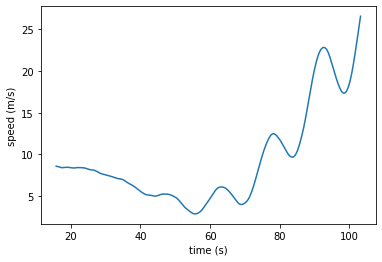

idle_duration = 385.22562255859407


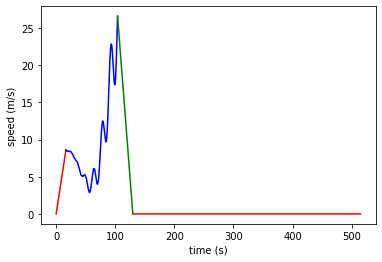

[[Variables]]
    A1_FS:   -989.105215 +/- 14372552.3 (1453086.29%) (init = 10)
    A2_FS:    140.739035 +/- 45568.2308 (32377.82%) (init = 10)
    A3_FS:    139.125356 +/- 45568.6280 (32753.65%) (init = 10)
    w1_FS:    3.8652e-30 +/- 5.3035e-06 (137210014406882941080698880.00%) (init = 0)
    w2_FS:    0.02961591 +/- 0.05773513 (194.95%) (init = 0.03141593)
    w3_FS:    0.02996671 +/- 0.05654698 (188.70%) (init = 0.06283185)
    phi1_FS:  4.4538e-04 +/- 6.47212099 (1453167.81%) (init = 0)
    phi2_FS: -1.94325375 +/- 10.5953573 (545.24%) (init = 0)
    phi3_FS:  1.13388139 +/- 10.4028341 (917.45%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(A2_FS, A3_FS)     =  1.000
    C(A1_FS, phi1_FS)   =  1.000
    C(w2_FS, phi2_FS)   = -1.000
    C(w3_FS, phi3_FS)   = -1.000
    C(A2_FS, phi3_FS)   =  1.000
    C(A3_FS, phi3_FS)   =  1.000
    C(A3_FS, phi2_FS)   = -1.000
    C(A2_FS, phi2_FS)   = -1.000
    C(A3_FS, w2_FS)     =  1.000
    C(A2_FS, w2_FS)     =  1

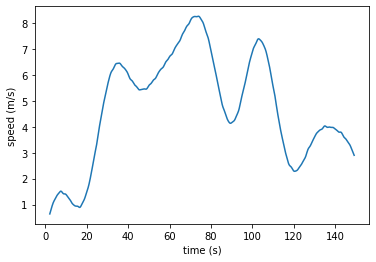

idle_duration = 3718.774331665046


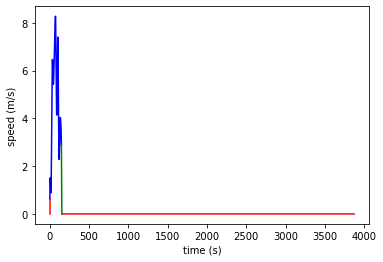

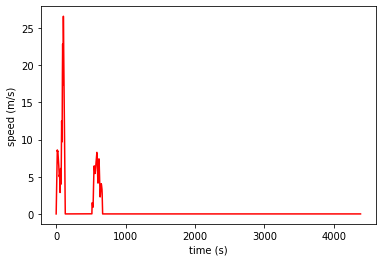

In [33]:
if __name__ == '__main__':
    # loads the csv file and extract the attribute informations
    # file_name = 'device12_oct_classified.csv'
    file_name = 'device12_oct_7_to_10_classified_updated.csv'
    subdir = ''
    extract_obj = Extract_Hist(file_name, subdir)
    
    drive_cycle = DC(1)
    drive_cycle.generate_drive_cycle(extract_obj)

/Users/koeboonshyang/Documents/GitHub/MEng-V2I
/Users/koeboonshyang/opt/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/koeboonshyang/opt/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
[[Variables]]
    A1_FS:    849.378246 +/-        nan (nan%) (init = 10)
    A2_FS:    20.7825229 +/- 234.694067 (1129.29%) (init = 10)
    A3_FS:    15.1164536 +/- 253.385844 (1676.23%) (init = 10)
    w1_FS:    1.5260e-07 +/-        nan (nan%) (init = 0)
    w2_FS:    0.04791387 +/- 0.14113960 (294.57%) (init = 0.03141593)
    w3_FS:    0.06283184 +/- 0.09506480 (151.30%) (init = 0.06283185)
    phi1_FS: -0.00784351 +/-        nan (nan%) (init = 0)
    phi2_FS: -0.49486919 +/- 6.18221140 (1249.26%) (init = 0)
    phi3_FS:  1.99500712 +/- 4.14355679 (207.70%) (

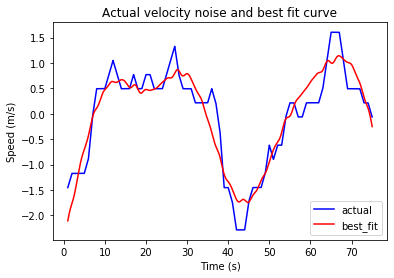

In [15]:
if __name__ == '__main__':
    # loads the csv file and extract the attribute informations
    # file_name = 'device12_oct_classified.csv'
    file_name = 'device12_oct_7_to_10_classified_updated.csv'
    subdir = ''
    extract_obj = Extract_Hist(file_name, subdir)
    # get the slice of ONLY cruising period
    cruising_data = extract_obj.cruise_with_vn[0]
    # create a numpy array of just t values starting at t=1
    t = np.linspace(1,len(cruising_data),len(cruising_data))
    # create a numpy array of speed_mps values
    y = cruising_data.to_numpy()
    # interpolate linearly and make timesteps finer (0.001s)
    from scipy.interpolate import interp1d
    f = interp1d(t, y)
    t = np.linspace(1,len(cruising_data),1000*len(cruising_data))
    y = f(t)

    # initialise the VN object
    vn_obj = Velocity_Noise(t,y)
    # deduct the average from the cruising period speed values (from fig3a to fig3b) and store as y
    y = vn_obj.subtract_avg()

    original_y = y
    
    # perform NLLSR with the initial parameters suggested by LMParams
    hi = vn_obj.fit_all()
    yy = vn_obj.final_curve()
    

    plt.plot(t,y,'b', label='actual')
    plt.plot(t, yy,'r', label = 'best_fit')
    plt.legend(loc='best')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title('Actual velocity noise and best fit curve')
    plt.show()



In [30]:
pulse_duration=500
driving_pulse = DP(pulse_duration, extract_obj)

# plt.plot(t,y,'b')
# plt.plot(t, yy,'r', label = 'best_fit')
# plt.legend(loc='best')
# plt.show()


# driving_pulse.generate_driving_pulse(vn_obj)


[[Variables]]
    alpha_1:  31.1794135 +/- 0.23688135 (0.76%) (init = 1)
    alpha_2:  3.18500684 +/- 0.15885568 (4.99%) (init = 1)
    sigma_1:  0.43147327 +/- 0.00338267 (0.78%) (init = 1)
    sigma_2:  0.09287673 +/- 0.00372095 (4.01%) (init = 1)
    meu_1:    0.82755287 +/- 0.00367360 (0.44%) (init = 1)
    meu_2:    0.64310530 +/- 0.00306460 (0.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_2, sigma_2) =  0.768
    C(alpha_1, alpha_2) = -0.616
    C(alpha_2, meu_1)   =  0.561
    C(alpha_1, sigma_2) = -0.481
    C(alpha_2, sigma_1) =  0.422
    C(sigma_2, meu_1)   =  0.406
    C(alpha_1, meu_1)   = -0.355
    C(sigma_1, sigma_2) =  0.288
    C(sigma_1, meu_2)   =  0.237
    C(sigma_1, meu_1)   =  0.203
    C(alpha_1, sigma_1) =  0.153
    C(meu_1, meu_2)     = -0.134
[[Variables]]
    alpha_1:  5681.34543 +/- 229.423070 (4.04%) (init = 1)
    alpha_2:  3990.89049 +/- 177.037141 (4.44%) (init = 1)
    sigma_1:  86.2030038 +/- 3.04282075 (3.53%) (

[771, 21, 634, 749, 499]
{'acceleration': 0.7789489746093746, 'decceleration': 0.10193252563476482, 'acceleration duration': 9701.0, 'decceleration duration': 74136.0, 'cruising duration': 170703.0, 'cruising speed': 7.556853485107436, 'idle duration': 245459.82641106643, 'total duration': 500000}
0.21209992626362648
21


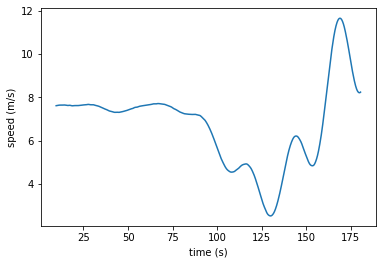

idle_duration = 3764.5810569763253


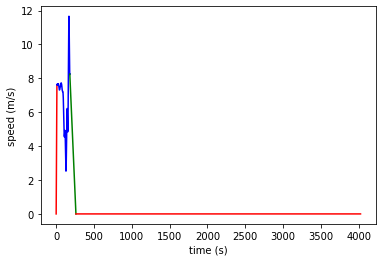

[225, 198, 761, 169, 88]
{'acceleration': 0.26710586547851495, 'decceleration': 0.540827941894531, 'acceleration duration': 31141.0, 'decceleration duration': 15380.0, 'cruising duration': 35939.0, 'cruising speed': 8.31800689697267, 'idle duration': 417540.0426943272, 'total duration': 500000}


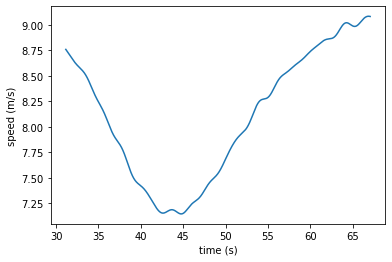

idle_duration = 1055.3401847839377


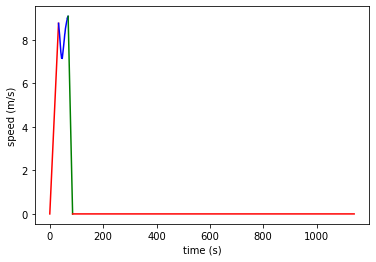

[685, 953, 4, 512, 813]
{'acceleration': 1.181369781494141, 'decceleration': 2.012518310546877, 'acceleration duration': 1244.0, 'decceleration duration': 730.0, 'cruising duration': 90275.0, 'cruising speed': 1.4691154479980482, 'idle duration': 407751.861488255, 'total duration': 500000}
0.43883539258832027
43


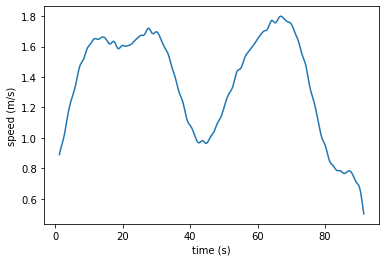

idle_duration = 3375.661478424079


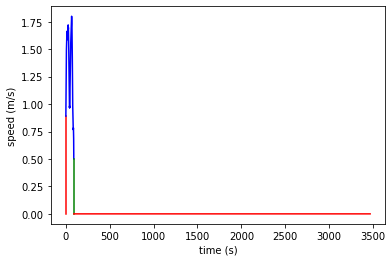

speed
0        0.000000
1        0.001181
2        0.002363
3        0.003544
4        0.004725
...           ...
3466935  0.000000
3466936  0.000000
3466937  0.000000
3466938  0.000000
3466939  0.000000

[3466940 rows x 1 columns]

In [31]:
# driving_pulse.pulse_duration = 100000
driving_pulse.generate_driving_pulse(vn_obj)
driving_pulse.generate_driving_pulse(vn_obj)
driving_pulse.generate_driving_pulse(vn_obj)
# driving_pulse.generate_driving_pulse(vn_obj)
# driving_pulse.generate_driving_pulse(vn_obj)
# driving_pulse.generate_driving_pulse(vn_obj)
# driving_pulse.generate_driving_pulse(vn_obj)
# driving_pulse.generate_driving_pulse(vn_obj)

# np.random.seed(10)
# list1 = np.random.rand(4).tolist()
# random_numbers = [0.17,0.09,0.69,0.95]
# # print(random_numbers)
# print(driving_pulse.accel_inv_cdf_obj.get_value(random_numbers.pop())[0])
# print(driving_pulse.cruising_duration_inv_cdf_obj.get_value(random_numbers.pop())[0])
# print(driving_pulse.avg_cruising_speed_inv_cdf_obj.get_value(random_numbers.pop())[0])
# print(driving_pulse.decel_inv_cdf_obj.get_value(random_numbers.pop())[0])
# print(driving_pulse.params['acceleration duration'])

# the code below plots all the histograms for all the attributes

[[Variables]]
    alpha_1:  31.1794135 +/- 0.23688135 (0.76%) (init = 1)
    alpha_2:  3.18500684 +/- 0.15885568 (4.99%) (init = 1)
    sigma_1:  0.43147327 +/- 0.00338267 (0.78%) (init = 1)
    sigma_2:  0.09287673 +/- 0.00372095 (4.01%) (init = 1)
    meu_1:    0.82755287 +/- 0.00367360 (0.44%) (init = 1)
    meu_2:    0.64310530 +/- 0.00306460 (0.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_2, sigma_2) =  0.768
    C(alpha_1, alpha_2) = -0.616
    C(alpha_2, meu_1)   =  0.561
    C(alpha_1, sigma_2) = -0.481
    C(alpha_2, sigma_1) =  0.422
    C(sigma_2, meu_1)   =  0.406
    C(alpha_1, meu_1)   = -0.355
    C(sigma_1, sigma_2) =  0.288
    C(sigma_1, meu_2)   =  0.237
    C(sigma_1, meu_1)   =  0.203
    C(alpha_1, sigma_1) =  0.153
    C(meu_1, meu_2)     = -0.134


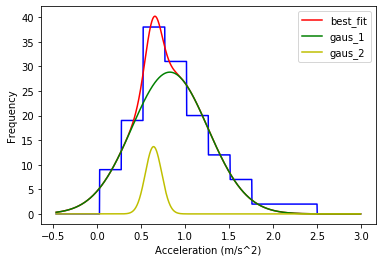

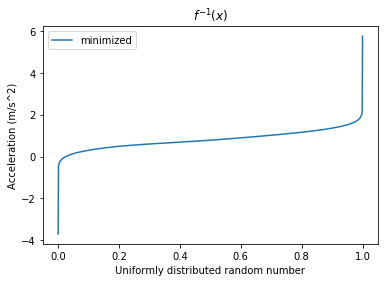

[[Variables]]
    alpha_1:  9.76682548 +/- 3.09652898 (31.70%) (init = 1)
    alpha_2:  31.3737804 +/- 2.97136926 (9.47%) (init = 1)
    sigma_1:  0.61017610 +/- 0.09801461 (16.06%) (init = 1)
    sigma_2:  0.34436350 +/- 0.01022380 (2.97%) (init = 1)
    meu_1:    1.49330622 +/- 0.20845353 (13.96%) (init = 1)
    meu_2:    0.78273725 +/- 0.00571172 (0.73%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, alpha_2) = -0.995
    C(alpha_2, meu_1)   =  0.994
    C(alpha_1, meu_1)   = -0.991
    C(alpha_1, sigma_1) =  0.965
    C(alpha_2, sigma_2) =  0.964
    C(sigma_1, meu_1)   = -0.955
    C(alpha_2, sigma_1) = -0.955
    C(alpha_1, sigma_2) = -0.954
    C(sigma_2, meu_1)   =  0.946
    C(sigma_1, sigma_2) = -0.884
    C(sigma_2, meu_2)   =  0.763
    C(alpha_2, meu_2)   =  0.736
    C(alpha_1, meu_2)   = -0.728
    C(meu_1, meu_2)     =  0.724
    C(sigma_1, meu_2)   = -0.574


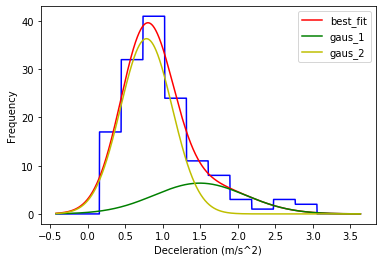

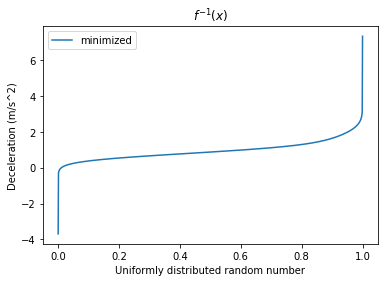

[[Variables]]
    alpha_1:  5681.34543 +/- 229.423070 (4.04%) (init = 1)
    alpha_2:  3990.89049 +/- 177.037141 (4.44%) (init = 1)
    sigma_1:  86.2030038 +/- 3.04282075 (3.53%) (init = 1)
    sigma_2:  27.9329795 +/- 0.76485522 (2.74%) (init = 1)
    meu_1:    154.908157 +/- 4.15827356 (2.68%) (init = 1)
    meu_2:    51.3699719 +/- 0.50274853 (0.98%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_2, meu_1)   =  0.902
    C(alpha_1, alpha_2) = -0.896
    C(alpha_2, sigma_2) =  0.860
    C(alpha_1, sigma_1) =  0.855
    C(alpha_1, meu_1)   = -0.809
    C(alpha_2, sigma_1) = -0.782
    C(sigma_2, meu_1)   =  0.751
    C(alpha_1, sigma_2) = -0.750
    C(sigma_1, meu_1)   = -0.705
    C(sigma_1, sigma_2) = -0.618
    C(sigma_1, meu_2)   =  0.138


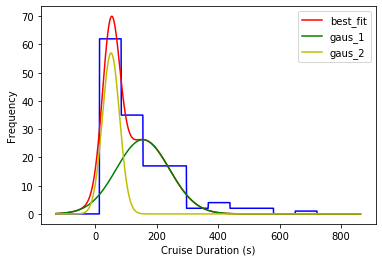

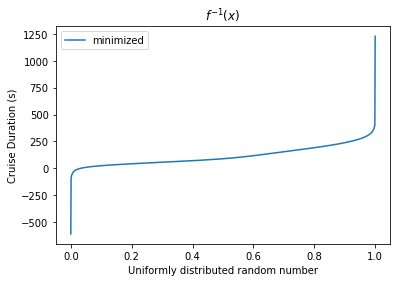

[[Variables]]
    alpha_1:  103.982248 +/- 1.61370151 (1.55%) (init = 1)
    alpha_2:  45.3915030 +/- 1.46631712 (3.23%) (init = 1)
    sigma_1:  1.62725948 +/- 0.02816293 (1.73%) (init = 1)
    sigma_2:  1.07088633 +/- 0.02876045 (2.69%) (init = 1)
    meu_1:    7.66155852 +/- 0.02826960 (0.37%) (init = 1)
    meu_2:    3.85310240 +/- 0.03229474 (0.84%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, sigma_1) =  0.857
    C(alpha_2, sigma_2) =  0.813
    C(alpha_1, alpha_2) = -0.793
    C(alpha_2, sigma_1) = -0.778
    C(alpha_2, meu_1)   =  0.775
    C(alpha_1, meu_2)   = -0.717
    C(meu_1, meu_2)     =  0.712
    C(sigma_1, meu_2)   = -0.693
    C(alpha_2, meu_2)   =  0.681
    C(alpha_1, meu_1)   = -0.676
    C(sigma_2, meu_1)   =  0.664
    C(sigma_1, meu_1)   = -0.654
    C(alpha_1, sigma_2) = -0.653
    C(sigma_1, sigma_2) = -0.578
    C(sigma_2, meu_2)   =  0.559


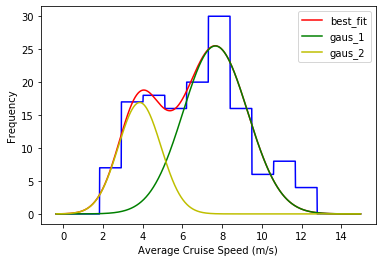

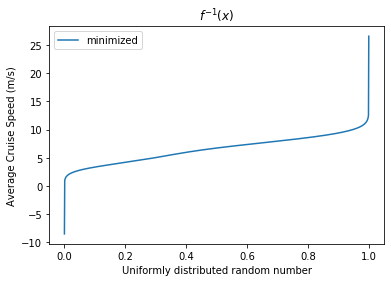

[[Variables]]
    alpha_1:  347223.833 +/- 10456.7169 (3.01%) (init = 100)
    alpha_2:  313154.534 +/- 10306.4692 (3.29%) (init = 50)
    sigma_1:  962.955664 +/- 26.5999615 (2.76%) (init = 100)
    sigma_2:  884.924404 +/- 24.5381612 (2.77%) (init = 100)
    meu_1:    3605.16773 +/- 31.6056675 (0.88%) (init = 2500)
    meu_2:    1121.97366 +/- 30.2770434 (2.70%) (init = 5000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, sigma_1) =  0.895
    C(alpha_2, sigma_2) =  0.884
    C(alpha_1, alpha_2) = -0.884
    C(alpha_2, meu_1)   =  0.870
    C(alpha_1, meu_2)   = -0.862
    C(meu_1, meu_2)     =  0.853
    C(alpha_2, meu_2)   =  0.826
    C(alpha_1, meu_1)   = -0.826
    C(alpha_2, sigma_1) = -0.822
    C(sigma_1, meu_2)   = -0.806
    C(alpha_1, sigma_2) = -0.799
    C(sigma_2, meu_1)   =  0.797
    C(sigma_1, meu_1)   = -0.763
    C(sigma_2, meu_2)   =  0.744
    C(sigma_1, sigma_2) = -0.678


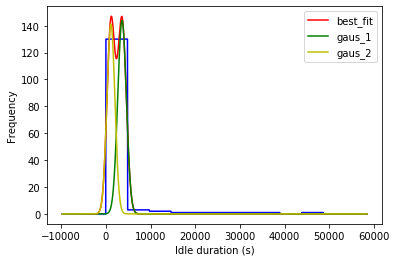

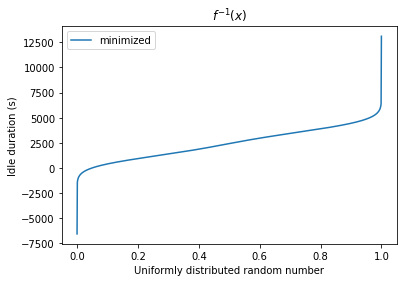

In [32]:
#plot the histogram, each gaussian component and the combined gaussian curve
plt.plot(extract_obj.accel_obj.bins,extract_obj.accel_obj.data_points,'b')

#load initial gaussian parameters
param_obj = Gaussian_param()
#create a probability function object for attribute with its attribute histogram data
attribute_prob_obj = Probability_Functions(extract_obj.accel_obj.bins, extract_obj.accel_obj.data_points,2)
#fit the histogram
fitted_obj = attribute_prob_obj.NLLSR(param_obj)

yy = attribute_prob_obj.eqn_model(fitted_obj.params)
gaus_1 = attribute_prob_obj.single_component(fitted_obj.params['alpha_1'],fitted_obj.params['sigma_1'],fitted_obj.params['meu_1'])
gaus_2 = attribute_prob_obj.single_component(fitted_obj.params['alpha_2'],fitted_obj.params['sigma_2'],fitted_obj.params['meu_2'])
plt.plot(attribute_prob_obj.x, yy,'r', label = 'best_fit')
plt.plot(attribute_prob_obj.x, gaus_1,'g', label = 'gaus_1')
plt.plot(attribute_prob_obj.x, gaus_2,'y', label = 'gaus_2')
plt.xlabel('Acceleration (m/s^2)')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

plt.plot(driving_pulse.accel_inv_cdf_obj.x,driving_pulse.accel_inv_cdf_obj.y,  label = 'minimized')
plt.title(r'$f^{-1}(x)$')
plt.xlabel('Uniformly distributed random number')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(loc='best')
plt.show()

#plot the histogram, each gaussian component and the combined gaussian curve
plt.plot(extract_obj.decel_obj.bins,extract_obj.decel_obj.data_points,'b')

#create a probability function object for attribute with its attribute histogram data
attribute_prob_obj = Probability_Functions(extract_obj.decel_obj.bins, extract_obj.decel_obj.data_points,2)
#fit the histogram
fitted_obj = attribute_prob_obj.NLLSR(param_obj)

yy = attribute_prob_obj.eqn_model(fitted_obj.params)
gaus_1 = attribute_prob_obj.single_component(fitted_obj.params['alpha_1'],fitted_obj.params['sigma_1'],fitted_obj.params['meu_1'])
gaus_2 = attribute_prob_obj.single_component(fitted_obj.params['alpha_2'],fitted_obj.params['sigma_2'],fitted_obj.params['meu_2'])
plt.plot(attribute_prob_obj.x, yy,'r', label = 'best_fit')
plt.plot(attribute_prob_obj.x, gaus_1,'g', label = 'gaus_1')
plt.plot(attribute_prob_obj.x, gaus_2,'y', label = 'gaus_2')
plt.xlabel('Deceleration (m/s^2)')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

plt.plot(driving_pulse.decel_inv_cdf_obj.x,driving_pulse.decel_inv_cdf_obj.y,  label = 'minimized')
plt.title(r'$f^{-1}(x)$')
plt.xlabel('Uniformly distributed random number')
plt.ylabel('Deceleration (m/s^2)')
plt.legend(loc='best')
plt.show()

#plot the histogram, each gaussian component and the combined gaussian curve
plt.plot(extract_obj.cd_obj.bins,extract_obj.cd_obj.data_points,'b')

#create a probability function object for attribute with its attribute histogram data
attribute_prob_obj = Probability_Functions(extract_obj.cd_obj.bins, extract_obj.cd_obj.data_points,2)
#fit the histogram
fitted_obj = attribute_prob_obj.NLLSR(param_obj)

yy = attribute_prob_obj.eqn_model(fitted_obj.params)
gaus_1 = attribute_prob_obj.single_component(fitted_obj.params['alpha_1'],fitted_obj.params['sigma_1'],fitted_obj.params['meu_1'])
gaus_2 = attribute_prob_obj.single_component(fitted_obj.params['alpha_2'],fitted_obj.params['sigma_2'],fitted_obj.params['meu_2'])
plt.plot(attribute_prob_obj.x, yy,'r', label = 'best_fit')
plt.plot(attribute_prob_obj.x, gaus_1,'g', label = 'gaus_1')
plt.plot(attribute_prob_obj.x, gaus_2,'y', label = 'gaus_2')
plt.xlabel('Cruise Duration (s)')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

plt.plot(driving_pulse.cruising_duration_inv_cdf_obj.x,driving_pulse.cruising_duration_inv_cdf_obj.y,  label = 'minimized')
plt.title(r'$f^{-1}(x)$')
plt.xlabel('Uniformly distributed random number')
plt.ylabel('Cruise Duration (s)')
plt.legend(loc='best')
plt.show()

#plot the histogram, each gaussian component and the combined gaussian curve
plt.plot(extract_obj.avg_cs_obj.bins,extract_obj.avg_cs_obj.data_points,'b')

#create a probability function object for attribute with its attribute histogram data
attribute_prob_obj = Probability_Functions(extract_obj.avg_cs_obj.bins, extract_obj.avg_cs_obj.data_points,2)
#fit the histogram
fitted_obj = attribute_prob_obj.NLLSR(param_obj)

yy = attribute_prob_obj.eqn_model(fitted_obj.params)
gaus_1 = attribute_prob_obj.single_component(fitted_obj.params['alpha_1'],fitted_obj.params['sigma_1'],fitted_obj.params['meu_1'])
gaus_2 = attribute_prob_obj.single_component(fitted_obj.params['alpha_2'],fitted_obj.params['sigma_2'],fitted_obj.params['meu_2'])
plt.plot(attribute_prob_obj.x, yy,'r', label = 'best_fit')
plt.plot(attribute_prob_obj.x, gaus_1,'g', label = 'gaus_1')
plt.plot(attribute_prob_obj.x, gaus_2,'y', label = 'gaus_2')
plt.xlabel('Average Cruise Speed (m/s)')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

plt.plot(driving_pulse.avg_cruising_speed_inv_cdf_obj.x,driving_pulse.avg_cruising_speed_inv_cdf_obj.y,  label = 'minimized')
plt.title(r'$f^{-1}(x)$')
plt.xlabel('Uniformly distributed random number')
plt.ylabel('Average Cruise Speed (m/s)')
plt.legend(loc='best')
plt.show()

#plot the histogram, each gaussian component and the combined gaussian curve
plt.plot(extract_obj.idle_obj.bins,extract_obj.idle_obj.data_points,'b')


param_obj = Gaussian_idle_param()
#create a probability function object for attribute with its attribute histogram data
attribute_prob_obj = Probability_Functions(extract_obj.idle_obj.bins, extract_obj.idle_obj.data_points,2)
#fit the histogram
fitted_obj = attribute_prob_obj.NLLSR(param_obj)

yy = attribute_prob_obj.eqn_model(fitted_obj.params)
gaus_1 = attribute_prob_obj.single_component(fitted_obj.params['alpha_1'],fitted_obj.params['sigma_1'],fitted_obj.params['meu_1'])
gaus_2 = attribute_prob_obj.single_component(fitted_obj.params['alpha_2'],fitted_obj.params['sigma_2'],fitted_obj.params['meu_2'])
plt.plot(attribute_prob_obj.x, yy,'r', label = 'best_fit')
plt.plot(attribute_prob_obj.x, gaus_1,'g', label = 'gaus_1')
plt.plot(attribute_prob_obj.x, gaus_2,'y', label = 'gaus_2')
plt.xlabel('Idle duration (s)')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

plt.plot(driving_pulse.idle_inv_cdf_obj.x,driving_pulse.idle_inv_cdf_obj.y,  label = 'minimized')
plt.title(r'$f^{-1}(x)$')
plt.xlabel('Uniformly distributed random number')
plt.ylabel('Idle duration (s)')
plt.legend(loc='best')
plt.show()

# print(extract_obj.idle_obj.bins)